# Predição de Dengue - Modelos de Classificaao KNN e SVM

## Autor - Francisco Flávio Cardoso Gomes
## Fonte de dados 
###  - Dados Metereológicos - Inmet - Instituto Nacional de Metereologia
###  - Dados de Infectados por dengue - SinanWeb - Sistema de Notificação de Agravos e Notificação

In [298]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import  pyplot as plt

from warnings import filterwarnings
filterwarnings('ignore')
import time as time

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler


### Ler Arquivos CSV

In [299]:
file='./Dados/Fortaleza/Fortaleza_Inmet_Diario.csv'
data = pd.read_csv(file,sep=',')
data = data.rename(columns={'Evaporacao Piche': 'Evaporacao', 'Temp Comp Media': 'TempMedia','Umidade Relativa Media':'Umidade','Velocidade do Vento Media':'VelVento'})
data


,Estacao,Data,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao,TempMedia,Umidade,VelVento,Semana,Ano
0,82397,01/01/2007,0,NaN,30.6,NaN,8.3,7.3,28.00,74.00,3.971840,1,2007
1,82397,01/01/2007,1200,0.0,NaN,27.4,NaN,NaN,NaN,NaN,NaN,1,2007
2,82397,02/01/2007,0,NaN,32.0,NaN,11.3,6.9,28.82,69.50,3.966667,1,2007
3,82397,02/01/2007,1200,0.0,NaN,27.1,NaN,NaN,NaN,NaN,NaN,1,2007
4,82397,03/01/2007,0,NaN,29.5,NaN,1.3,8.2,27.24,81.75,2.433333,1,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9667,82397,06/06/2020,1200,0.0,NaN,24.3,NaN,NaN,NaN,NaN,NaN,23,2020
9668,82397,08/06/2020,0,NaN,31.7,NaN,9.1,NaN,NaN,82.00,NaN,24,2020
9669,82397,08/06/2020,1200,4.2,NaN,23.3,NaN,NaN,NaN,NaN,NaN,24,2020
9670,82397,09/06/2020,0,NaN,30.5,NaN,6.4,NaN,NaN,90.00,NaN,24,2020


### Incluindo colunas Ano e Semana para Agrupamento

In [300]:

file2='./Dados/Fortaleza/Fortaleza_Infectados_Diarios.csv'
data2 = pd.read_csv(file2,sep=',')
data2 = data2.rename(columns={'Data_Notificacao':'Data','Infectados_Dengue':'Infectados'})
data2


,Data,Infectados,Semana,Ano
0,01/01/2007,6,1,2007
1,02/01/2007,10,1,2007
2,03/01/2007,26,1,2007
3,04/01/2007,20,1,2007
4,05/01/2007,22,1,2007
...,...,...,...,...
4921,22/06/2020,4,26,2020
4922,23/06/2020,4,26,2020
4923,24/06/2020,0,26,2020
4924,25/06/2020,0,26,2020


### Verificar dados faltando no dataset Inmet

In [301]:
tot_nulos=data.isnull().sum()
tot_nulos

Estacao            0
Data               0
Hora               0
Precipitacao    4827
TempMaxima      4850
TempMinima      4847
Insolacao       5022
Evaporacao      5495
TempMedia       5045
Umidade         5054
VelVento        4868
Semana             0
Ano                0
dtype: int64

In [302]:
data.head()

,Estacao,Data,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao,TempMedia,Umidade,VelVento,Semana,Ano
0,82397,01/01/2007,0,NaN,30.6,NaN,8.3,7.3,28.00,74.00,3.971840,1,2007
1,82397,01/01/2007,1200,0.0,NaN,27.4,NaN,NaN,NaN,NaN,NaN,1,2007
2,82397,02/01/2007,0,NaN,32.0,NaN,11.3,6.9,28.82,69.50,3.966667,1,2007
3,82397,02/01/2007,1200,0.0,NaN,27.1,NaN,NaN,NaN,NaN,NaN,1,2007
4,82397,03/01/2007,0,NaN,29.5,NaN,1.3,8.2,27.24,81.75,2.433333,1,2007


### Os dados diários estão duplicados, pois existem duas medições diáris. Vamos excluir uma das medições

In [303]:
data["Precipitacao"].fillna( method ='backfill', limit = 1, inplace = True) 
data["TempMinima"].fillna( method ='backfill', limit = 1, inplace = True) 
data["TempMaxima"].fillna( method ='backfill', limit = 1, inplace = True) 
data["Insolacao"].fillna( method ='backfill', limit = 1, inplace = True) 
data["Evaporacao"].fillna( method ='backfill', limit = 1, inplace = True) 
data["TempMedia"].fillna( method ='backfill', limit = 1, inplace = True) 
data["Umidade"].fillna( method ='backfill', limit = 1, inplace = True) 
data["VelVento"].fillna( method ='backfill', limit = 1, inplace = True) 

Indices=[x for x in data.index if x%2==1]
data.drop(Indices, inplace=True)
data.reset_index(inplace = True, drop = True)

data

,Estacao,Data,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao,TempMedia,Umidade,VelVento,Semana,Ano
0,82397,01/01/2007,0,0.0,30.6,27.4,8.3,7.3,28.00,74.00,3.971840,1,2007
1,82397,02/01/2007,0,0.0,32.0,27.1,11.3,6.9,28.82,69.50,3.966667,1,2007
2,82397,03/01/2007,0,0.5,29.5,25.9,1.3,8.2,27.24,81.75,2.433333,1,2007
3,82397,04/01/2007,0,7.9,31.3,25.9,11.2,3.1,27.80,71.50,3.166667,1,2007
4,82397,05/01/2007,0,2.7,28.7,24.0,3.0,5.9,26.52,83.75,3.766667,1,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4831,82397,04/06/2020,0,0.8,31.7,24.7,3.8,NaN,NaN,88.00,NaN,23,2020
4832,82397,05/06/2020,0,5.4,31.6,23.9,7.3,NaN,NaN,82.00,NaN,23,2020
4833,82397,06/06/2020,0,0.0,30.8,24.3,8.4,NaN,NaN,84.00,NaN,23,2020
4834,82397,08/06/2020,0,4.2,31.7,23.3,9.1,NaN,NaN,82.00,NaN,24,2020


### Verifica novamente se existem nulos

In [304]:
tot_nulos=data.isnull().sum()
tot_nulos

Estacao           0
Data              0
Hora              0
Precipitacao      1
TempMaxima       14
TempMinima       11
Insolacao       186
Evaporacao      659
TempMedia       209
Umidade         218
VelVento         32
Semana            0
Ano               0
dtype: int64

### Estes são nulos de verdade. Vamos substituir pela média

In [305]:
data['Precipitacao'].fillna(data['Precipitacao'].mean(),inplace=True)
data['TempMaxima'].fillna(data['TempMaxima'].mean(),inplace=True)
data['TempMinima'].fillna(data['TempMinima'].mean(),inplace=True)
data['Insolacao'].fillna(data['Insolacao'].mean(),inplace=True)
data['Evaporacao'].fillna(data['Evaporacao'].mean(),inplace=True)
data['TempMedia'].fillna(data['TempMedia'].mean(),inplace=True)
data['Umidade'].fillna(data['Umidade'].mean(),inplace=True)
data['VelVento'].fillna(data['VelVento'].mean(),inplace=True)
tot_nulos=data.isnull().sum()
tot_nulos

Estacao         0
Data            0
Hora            0
Precipitacao    0
TempMaxima      0
TempMinima      0
Insolacao       0
Evaporacao      0
TempMedia       0
Umidade         0
VelVento        0
Semana          0
Ano             0
dtype: int64

### Agrupando dados Metereológicos para Semanais

In [306]:
dataSemana = data.groupby(by=['Ano','Semana'], as_index=False)['Precipitacao','TempMaxima','TempMinima','Insolacao','Evaporacao','TempMedia',	'Umidade',	'VelVento'].sum()


In [307]:
dataSemana

,Ano,Semana,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao,TempMedia,Umidade,VelVento
0,2007,1,17.9,183.6,155.2,45.5,35.000000,166.320000,454.25,21.605174
1,2007,2,18.2,220.9,177.7,58.6,40.100000,195.440000,541.25,23.466666
2,2007,3,1.2,226.1,184.9,59.3,39.200000,199.820000,520.75,24.966668
3,2007,4,0.0,225.2,183.9,62.2,45.600000,199.860000,511.50,23.214440
4,2007,5,9.7,223.8,184.6,43.4,38.600000,198.180000,543.25,20.033333
...,...,...,...,...,...,...,...,...,...,...
704,2020,20,63.4,182.0,146.3,29.3,25.455830,164.632367,517.00,13.847808
705,2020,21,127.7,188.0,146.2,34.4,25.455830,163.057100,513.00,16.850305
706,2020,22,33.4,191.1,144.3,50.9,25.455830,163.057100,501.00,16.850305
707,2020,23,14.2,189.1,145.0,41.8,25.455830,163.057100,509.00,16.850305


### Examina o gráfico dos atributos

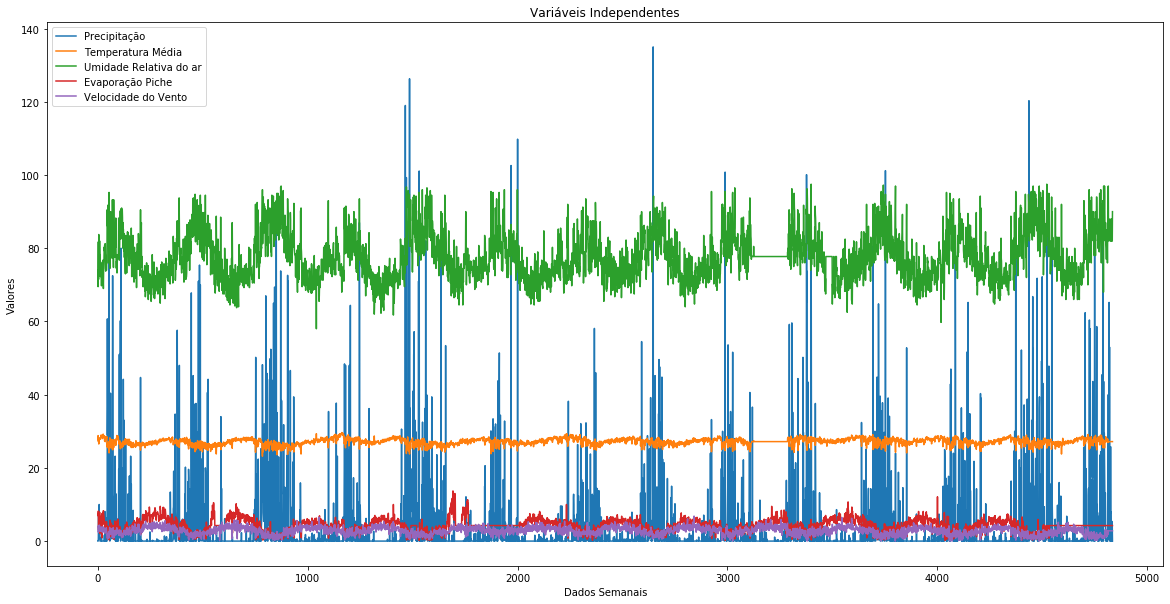

In [308]:

plt.figure(figsize=(20,10))
data.Precipitacao.plot(label="Precipitação")
data.TempMedia.plot( label="Temperatura Média")
data.Umidade.plot( label="Umidade Relativa do ar")
data.Evaporacao.plot( label="Evaporação Piche")
data.VelVento.plot( label="Velocidade do Vento")
plt.title("Variáveis Independentes")
plt.legend()
plt.xlabel('Dados Semanais')
plt.ylabel('Valores')

plt.show()

### Verifica Nulos da variável dependente - N. de infectados.

In [309]:
tot_nulos=data2.isnull().sum()
tot_nulos

Data          0
Infectados    0
Semana        0
Ano           0
dtype: int64

In [310]:
data2

,Data,Infectados,Semana,Ano
0,01/01/2007,6,1,2007
1,02/01/2007,10,1,2007
2,03/01/2007,26,1,2007
3,04/01/2007,20,1,2007
4,05/01/2007,22,1,2007
...,...,...,...,...
4921,22/06/2020,4,26,2020
4922,23/06/2020,4,26,2020
4923,24/06/2020,0,26,2020
4924,25/06/2020,0,26,2020


### Agrupar  por semana e plota o gráfico da variável dependente

In [311]:
data2Semana = data2.groupby(by=['Ano','Semana'], as_index=False).sum()
for col_name in data2Semana:
    print(col_name)
#data2Semana=data2

Ano
Semana
Infectados


In [312]:
data2Semana.describe()

,Ano,Semana,Infectados
count,715.000000,715.000000,715.000000
mean,2013.254545,26.509091,382.864336
std,3.902465,15.305237,773.811880
min,2007.000000,1.000000,1.000000
25%,2010.000000,13.000000,50.500000
50%,2013.000000,26.000000,126.000000
75%,2017.000000,40.000000,348.000000
max,2020.000000,53.000000,6233.000000


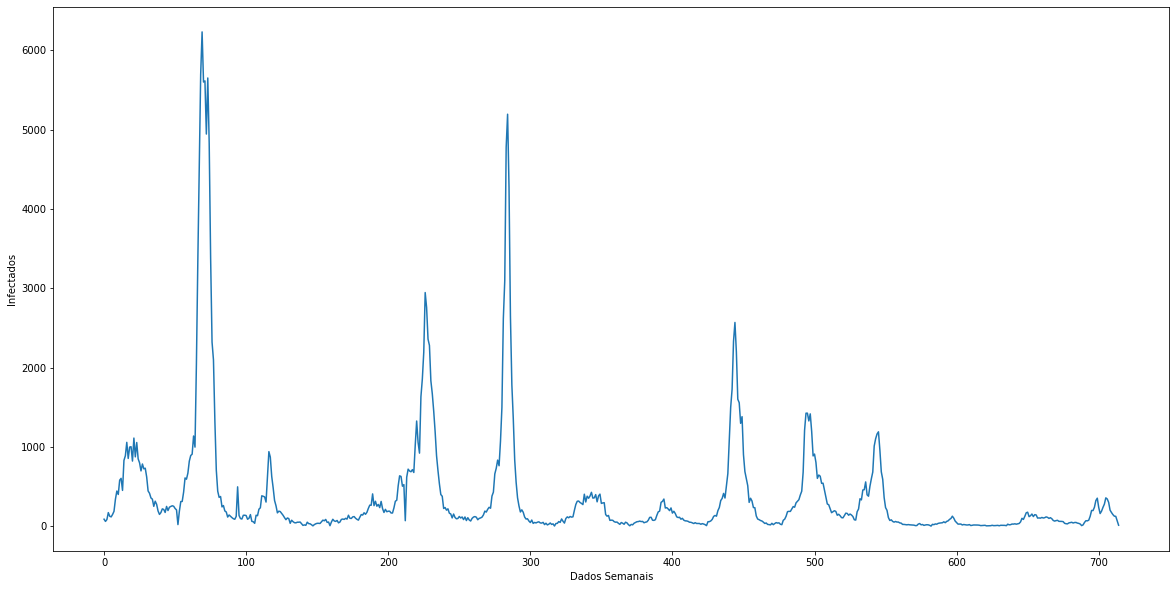

In [313]:
# Analisar dados de "Infectados" ao longo do tempo
plt.figure(figsize=(20,10))
plt.xlabel('Dados Semanais')
plt.ylabel('Infectados')
plt.plot(data2Semana['Infectados'])
plt.show()

### Separando dados para treino e teste

In [314]:
dataSemana.loc[:,'Ano']

0      2007
1      2007
2      2007
3      2007
4      2007
       ... 
704    2020
705    2020
706    2020
707    2020
708    2020
Name: Ano, Length: 709, dtype: int64

In [315]:
X_train=dataSemana.iloc[0:530]
X_test=dataSemana.iloc[531:709]
y_train = data2Semana.iloc[0:530]
submission = data2Semana.iloc[531:709]

X_train,X_test

(      Ano  Semana  Precipitacao  TempMaxima  TempMinima  Insolacao  \
 0    2007       1          17.9       183.6       155.2       45.5   
 1    2007       2          18.2       220.9       177.7       58.6   
 2    2007       3           1.2       226.1       184.9       59.3   
 3    2007       4           0.0       225.2       183.9       62.2   
 4    2007       5           9.7       223.8       184.6       43.4   
 ..    ...     ...           ...         ...         ...        ...   
 525  2016      49           0.0       228.7       180.9       71.4   
 526  2016      50           0.0       229.0       180.0       66.7   
 527  2016      51           7.6       225.0       177.3       47.5   
 528  2016      52          42.9       225.9       176.8       42.6   
 529  2016      53          23.7       225.2       177.6       53.4   
 
      Evaporacao  TempMedia  Umidade   VelVento  
 0          35.0     166.32   454.25  21.605174  
 1          40.1     195.44   541.25  23.46666

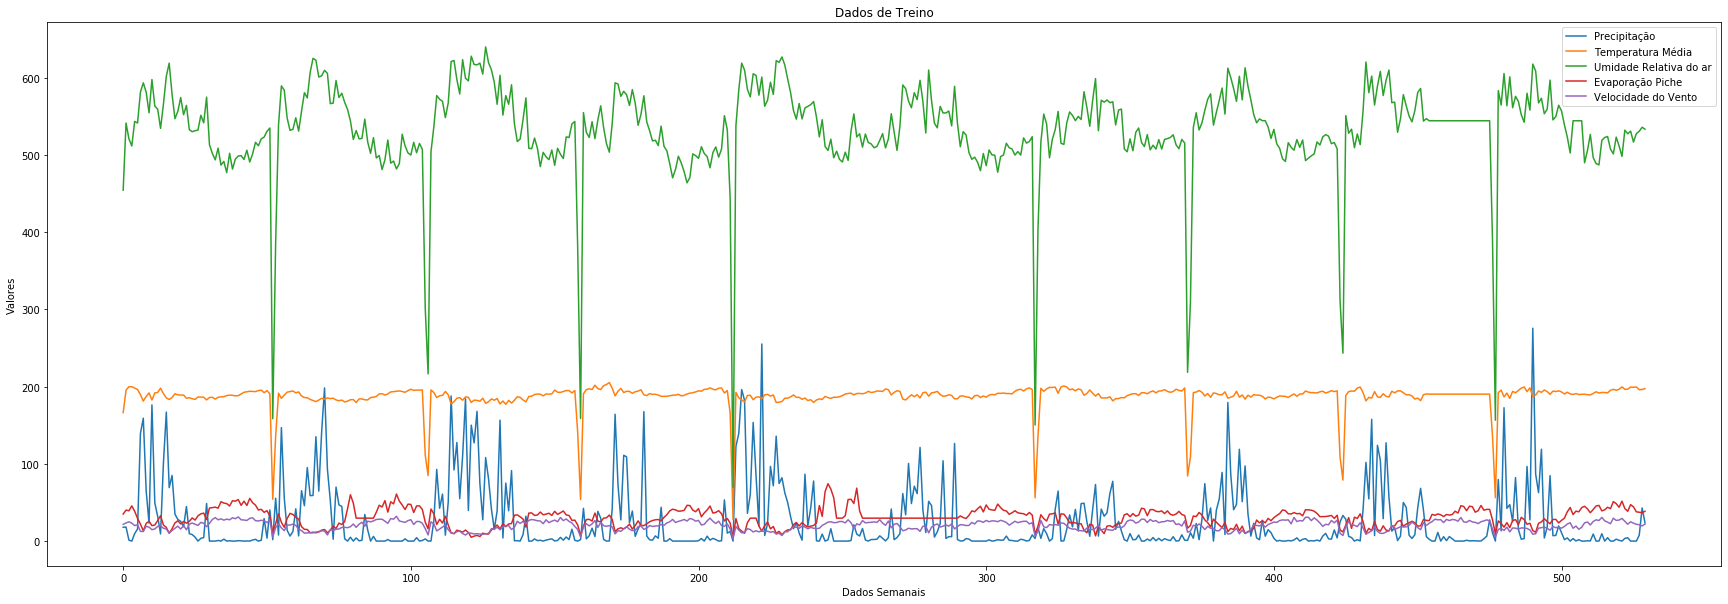

In [316]:
## Dados de Treino
plt.figure(figsize=(30,10))
X_train.Precipitacao.plot(label="Precipitação")
X_train.TempMedia.plot( label="Temperatura Média")
X_train.Umidade.plot( label="Umidade Relativa do ar")
X_train.Evaporacao.plot( label="Evaporação Piche")
X_train.VelVento.plot( label="Velocidade do Vento")
plt.title("Dados de Treino")
plt.legend()
plt.xlabel('Dados Semanais')
plt.ylabel('Valores')

plt.show()


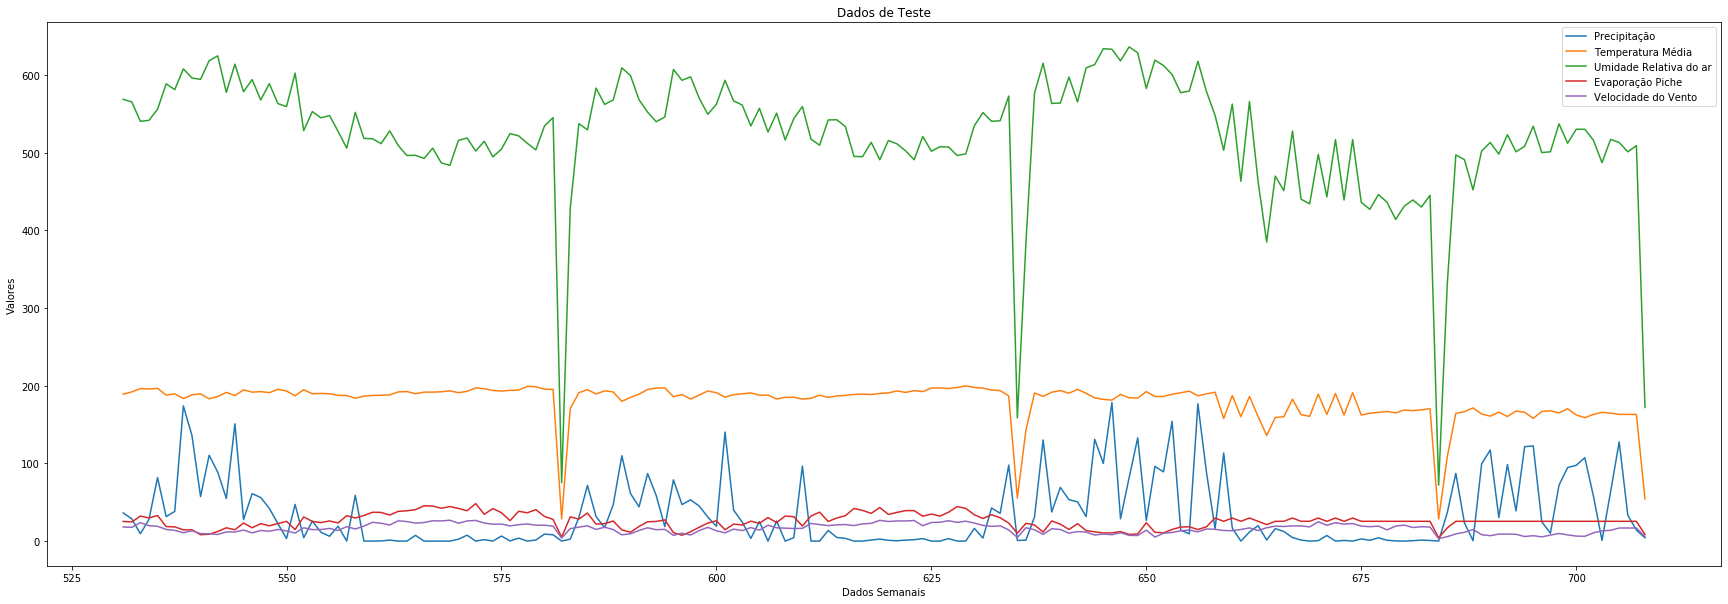

In [317]:
## Dados de Teste
plt.figure(figsize=(30,10))
X_test.Precipitacao.plot(label="Precipitação")
X_test.TempMedia.plot( label="Temperatura Média")
X_test.Umidade.plot( label="Umidade Relativa do ar")
X_test.Evaporacao.plot( label="Evaporação Piche")
X_test.VelVento.plot( label="Velocidade do Vento")
plt.title("Dados de Teste")
plt.legend()
plt.xlabel('Dados Semanais')
plt.ylabel('Valores')

plt.show()


### Normalizador estatístico, onde o resultado da normalização garante média zero e variância/desvio parão unitária.

In [318]:
normalizador = StandardScaler()

X_train.iloc[:,2:] = normalizador.fit_transform(X_train.iloc[:,2:])
X_test.iloc[:,2:] = normalizador.transform(X_test.iloc[:,2:])
X_train,X_test,

(      Ano  Semana  Precipitacao  TempMaxima  TempMinima  Insolacao  \
 0    2007       1     -0.220810   -1.548236   -0.578985  -0.594013   
 1    2007       2     -0.213987    0.222771    0.790910   0.279614   
 2    2007       3     -0.600628    0.469668    1.229277   0.326297   
 3    2007       4     -0.627920    0.426936    1.168393   0.519695   
 4    2007       5     -0.407307    0.360463    1.211012  -0.734060   
 ..    ...     ...           ...         ...         ...        ...   
 525  2016      49     -0.627920    0.593116    0.985740   1.133234   
 526  2016      50     -0.627920    0.607360    0.930944   0.819796   
 527  2016      51     -0.455069    0.417440    0.766557  -0.460635   
 528  2016      52      0.347779    0.460172    0.736114  -0.787411   
 529  2016      53     -0.088897    0.426936    0.784822  -0.067169   
 
      Evaporacao  TempMedia   Umidade  VelVento  
 0      0.441223  -1.152474 -1.276061  0.242582  
 1      0.888720   0.456992  0.132826  0.56309

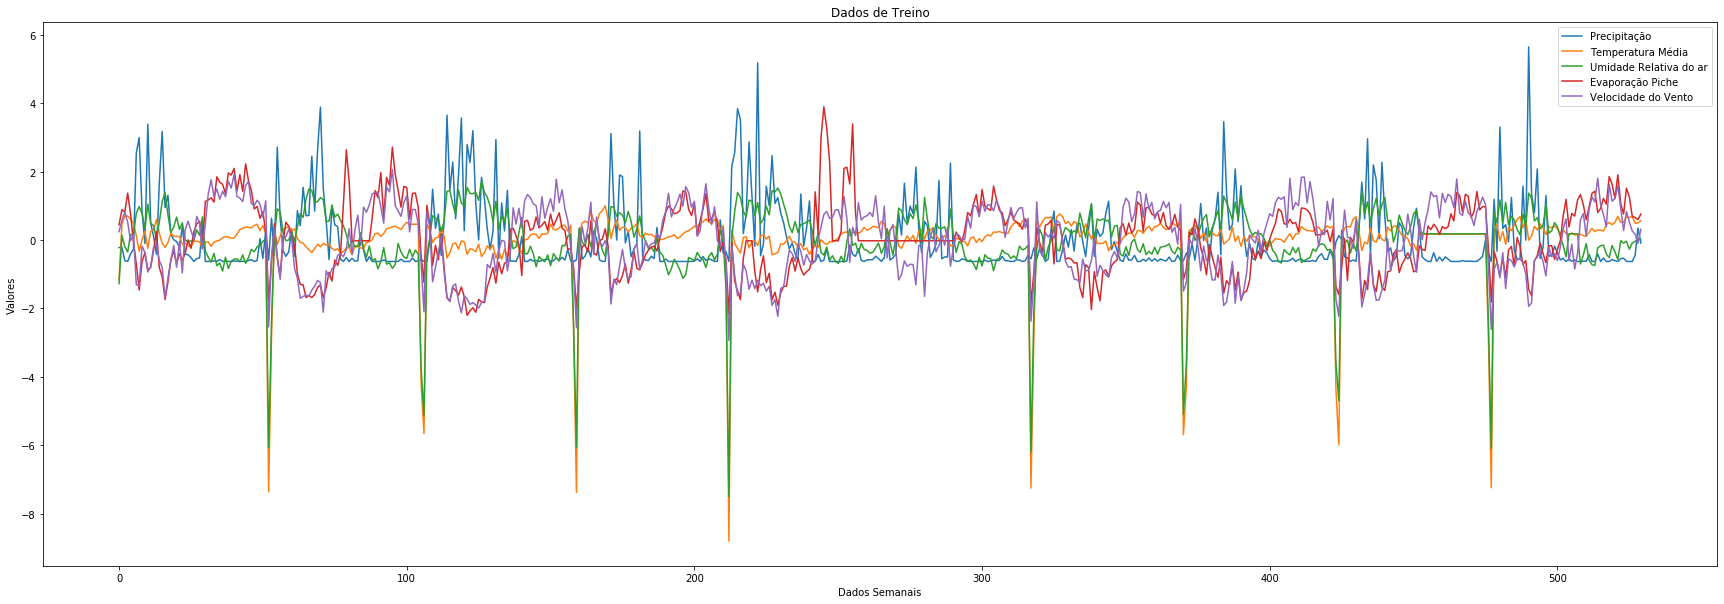

In [319]:
## Dados de Teste
plt.figure(figsize=(30,10))
X_train.Precipitacao.plot(label="Precipitação")
X_train.TempMedia.plot( label="Temperatura Média")
X_train.Umidade.plot( label="Umidade Relativa do ar")
X_train.Evaporacao.plot( label="Evaporação Piche")
X_train.VelVento.plot( label="Velocidade do Vento")
plt.title("Dados de Treino")
plt.legend()
plt.xlabel('Dados Semanais')
plt.ylabel('Valores')

plt.show()

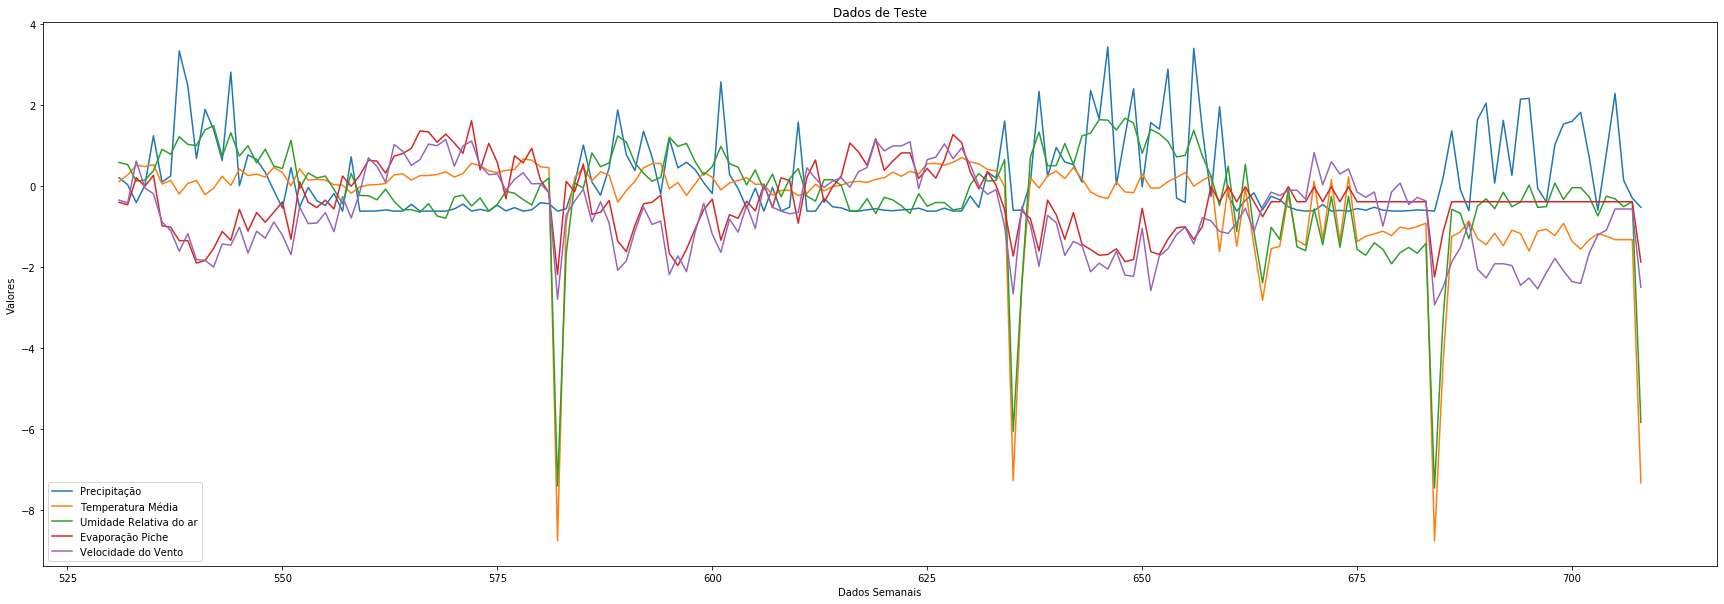

In [320]:
## Dados de Teste
plt.figure(figsize=(30,10))
X_test.Precipitacao.plot(label="Precipitação")
X_test.TempMedia.plot( label="Temperatura Média")
X_test.Umidade.plot( label="Umidade Relativa do ar")
X_test.Evaporacao.plot( label="Evaporação Piche")
X_test.VelVento.plot( label="Velocidade do Vento")
plt.title("Dados de Teste")
plt.legend()
plt.xlabel('Dados Semanais')
plt.ylabel('Valores')

plt.show()

Nossa variável de destino, "Infectados" é um número inteiro não negativo, o que significa que estamos procurando fazer algumas previsões de contagem. As técnicas de regressão padrão para esse tipo de previsão incluem:
Regressão de Poisson
Regressão binomial negativa.

Qual técnica terá melhor desempenho depende de muitas coisas, mas a escolha entre a regressão de Poisson e a regressão binomial negativa é bastante direta.

A regressão de Poisson se ajusta de acordo com a suposição de que a média e a variância da distribuição da população são iguais. Quando não são, especificamente quando a variação é muito maior que a média, a abordagem binomial negativa é melhor.

A regressão binomial negativa simplesmente levanta a suposição de que a média e variância da população são iguais, permitindo uma classe maior de modelos possíveis. De fato, dessa perspectiva, a distribuição de Poisson é apenas um caso especial da distribuição binomial negativa.

In [321]:
y_train.describe()

,Ano,Semana,Infectados
count,530.000000,530.00000,530.000000
mean,2011.500000,27.00000,472.086792
std,2.874995,15.31151,873.055725
min,2007.000000,1.00000,2.000000
25%,2009.000000,14.00000,76.000000
50%,2011.500000,27.00000,178.500000
75%,2014.000000,40.00000,424.000000
max,2016.000000,53.00000,6233.000000


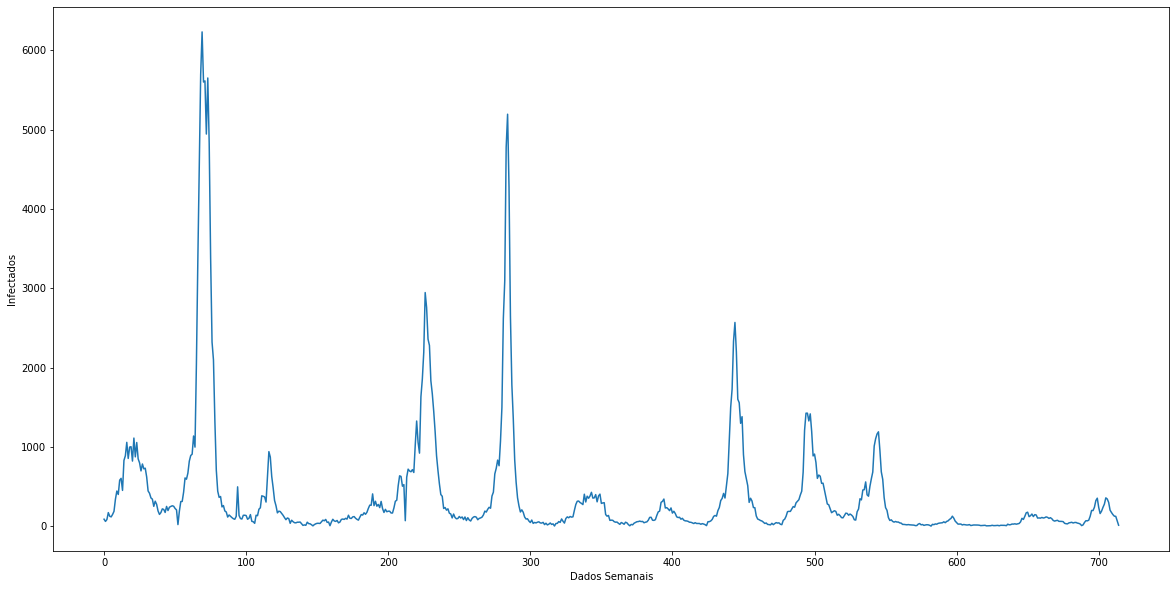

In [322]:
# Dados de "Infectados" de treino
plt.figure(figsize=(20,10))
plt.xlabel('Dados Semanais')
plt.ylabel('Infectados')
plt.plot(data2Semana['Infectados'])
plt.show()

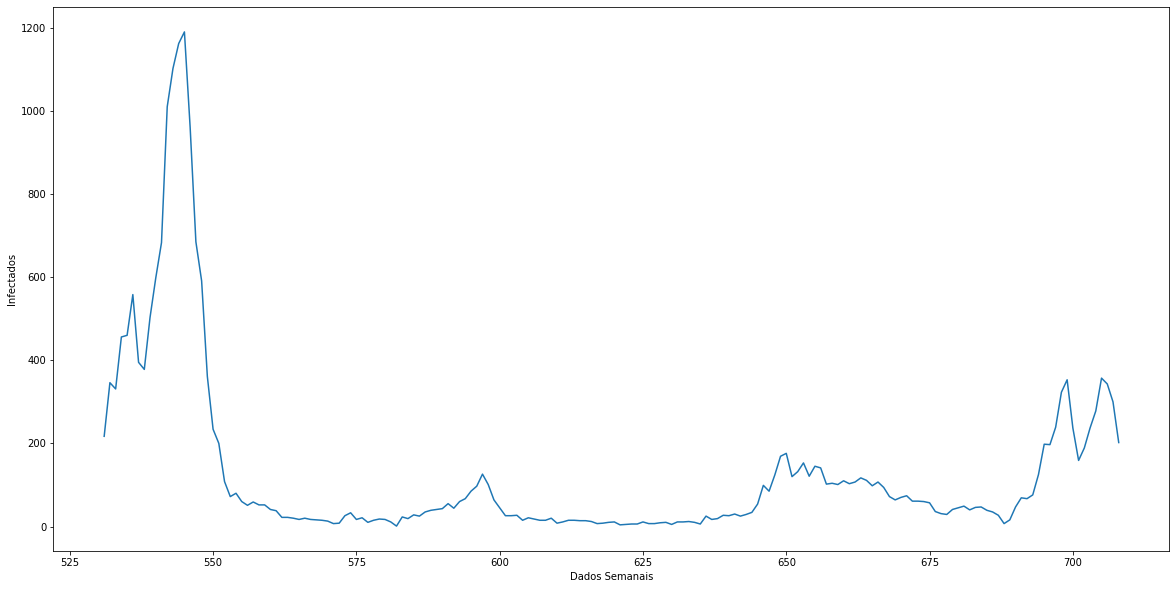

In [323]:
# Dados de "Infectados" de teste
plt.figure(figsize=(20,10))
plt.xlabel('Dados Semanais')
plt.ylabel('Infectados')
plt.plot(submission['Infectados'])
plt.show()

In [324]:
print('Media e Variancia dos Infectados')
print('mean: ', y_train.mean()[2])
print('std :', y_train.std()[2])
print('var :', y_train.var()[2])

Media e Variancia dos Infectados
mean:  472.0867924528302
std : 873.0557248486581
var : 762226.2986910157


Variancia maior que media sugere que a variável "Infectados" pode ser descrita por uma distribuição binomial negativa; portanto, usaremos uma regressão binomial negativa abaixo. 

Vamos analisar as Correlações


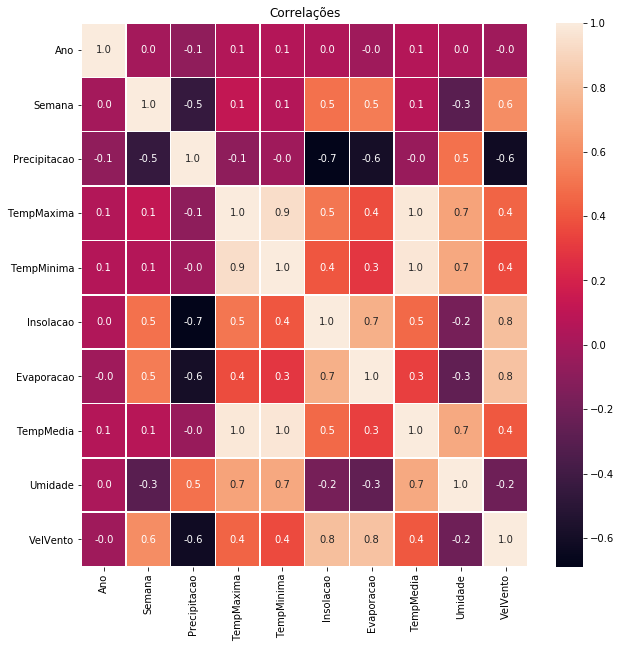

In [325]:
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(X_train.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
ax.set_title('Correlações')
plt.show()


### Verifica-se que TempMaxima e TemMinima estão fortemente relacionada com TempMedia, sugerindo que podemos excluir estes 2  atributos.

In [326]:
delete = ['TempMinima','TempMaxima']
for z in delete:
    del X_train[z]
    del X_test[z]

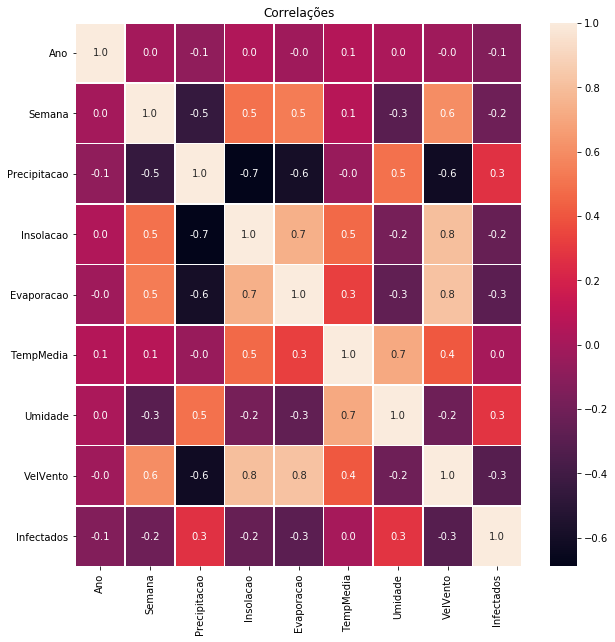

In [327]:
X_train['Infectados'] = y_train['Infectados']

f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(X_train.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
ax.set_title('Correlações')
plt.show()

### Vamos verificar a correlação dos atributos com a variável dependente

Text(0.5, 1.0, 'Correlações')

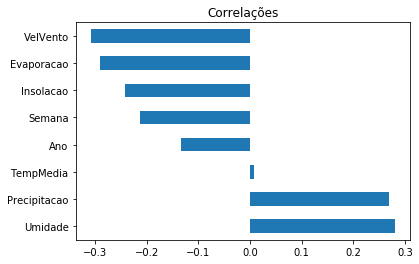

In [328]:
correlations = X_train.corr()
(correlations['Infectados'].drop('Infectados').sort_values(ascending=False).plot.barh())
plt.title('Correlações')

### Verificamos que Vel. Vento, Umidade e Evaporação estão mais fortemente correlacionadas com Infectados do que a precipitação. Isto foi uma surpresa

### Vamos plotar o número de infectados para cada ano

Text(0, 0.5, 'Total de Infectados')

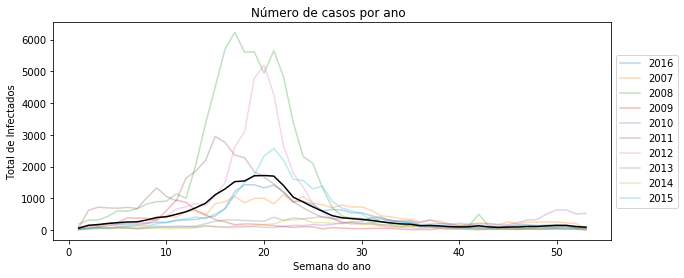

In [329]:
#Numero de Casos por semana
for i in set(y_train['Ano']):
    df = y_train[y_train['Ano'] == i]
    df.set_index('Semana', drop = True, inplace = True)
    plt.plot(df['Infectados'], alpha = .3)
    
y_train.groupby('Semana')['Infectados'].mean().plot(c = 'k', figsize = (10,4))
plt.legend(set(y_train['Ano']), loc='center left', bbox_to_anchor=(1, .5))

plt.title('Número de casos por ano  ')
plt.xlabel('Semana do ano')
plt.ylabel('Total de Infectados')

###  Verificas uma incidência maior de dengue no final do primeiro semestre, que coincide com o final do período chuvoso no Ceará

## Construindo modelos de Machine Learning
### Agora que temos uma compreensão mais clara do nosso conjunto de dados, continuaremos a construir nossos modelos de ML.


In [330]:
#features=['Infectados','Precipitacao','Insolacao','Evaporacao','TempMedia','Umidade','VelVento'] 
features=['Infectados','Precipitacao','Insolacao','Evaporacao','Umidade','VelVento'] 

X_train=X_train.join(X_train.groupby(['Semana'])['Infectados'].mean(), on=['Semana'], rsuffix='_avg')
X_test=X_test.join(X_train.groupby(['Semana'])['Infectados'].mean(), on=['Semana'], rsuffix='_avg')

#TRAIN
X= X_train[features]
Y = X_train['Infectados']

#TEST
Xt= X_test[features]
X.fillna(method='bfill', inplace=True)
Xt.fillna(method='bfill', inplace=True)


## Criando os modelos e treinando 

### SVM - (Support Vetor Machine / SRV - Support vetor Regression)

In [331]:
svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5,
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})
t0 = time.time()
svr.fit(X,Y)

svr_fit = time.time() - t0
print("Complexidade SVR e largura de banda selecionadas e modelo ajustado em %.3f s"
      % svr_fit)
model=svr.best_estimator_
print(model)


Complexidade SVR e largura de banda selecionadas e modelo ajustado em 3.225 s
SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


###   KNN (k-nearest neighbors )

In [332]:
knn = KNeighborsClassifier(n_neighbors = 30)
knn.fit(X,Y)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=30, p=2,
                     weights='uniform')

### Separa dados de TREINO (70%)  e teste (30%) Para VALIDAÇÃO

In [333]:
train_subtrain = X_train.sample(frac=0.7)
train_subtest = X_train.loc[~X_train.index.isin(train_subtrain.index)]

train_subtrain.fillna(method='bfill', inplace=True)
train_subtest.fillna(method='bfill', inplace=True)

#X_train.describe()
train_subtest.describe()


,Ano,Semana,Precipitacao,Insolacao,Evaporacao,TempMedia,Umidade,VelVento,Infectados,Infectados_avg
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,2011.559748,27.547170,-0.068914,-0.012503,-0.013372,-0.073165,-0.083533,-0.036994,450.786164,460.628931
std,2.945907,15.258406,0.881300,1.035961,0.989177,1.142577,1.122294,1.038285,843.857781,483.858200
min,2007.000000,1.000000,-0.627920,-3.341603,-2.112141,-7.375886,-6.199068,-2.564821,2.000000,57.300000
25%,2009.000000,15.000000,-0.627920,-0.610685,-0.708229,-0.070285,-0.444089,-0.762684,76.000000,131.800000
50%,2012.000000,28.000000,-0.482361,0.092885,-0.023957,0.158533,-0.000776,0.052294,182.000000,252.000000
75%,2014.000000,39.500000,0.255668,0.863144,0.761491,0.333187,0.501241,0.824229,388.000000,590.500000
max,2016.000000,53.000000,3.645598,1.466680,1.906556,0.808509,1.727944,1.837213,6233.000000,1717.000000


### Cria Predições

In [334]:
preds= model.predict(train_subtest[features]).astype(int)
newPreds = model.predict(X_test[features]).astype(int)
#SVM
#add to the dataframes
train_subtest['fitted'] = preds
X_test['fitted'] = newPreds

# KNN
preds2 = knn.predict(train_subtest[features]).astype(int)
newPreds2 = knn.predict(X_test[features]).astype(int)
train_subtest['fitted2'] = preds2
X_test['fitted2'] = newPreds2
#train_subtest.index = train_subtest['week_start_date']



In [335]:
X_test

,Ano,Semana,Precipitacao,Insolacao,Evaporacao,TempMedia,Umidade,VelVento,Infectados,fitted,fitted2
531,2017,2,0.197672,-0.387277,-0.409898,0.102158,0.574115,-0.355195,147.4,133,138
532,2017,3,0.024821,-0.447297,-0.471319,0.266862,0.521484,-0.424066,171.5,161,160
533,2017,4,-0.414131,0.446337,0.195539,0.503418,0.116631,0.609006,205.2,200,189
534,2017,5,0.004351,0.439668,-0.015048,0.472467,0.136874,-0.056752,230.4,221,235
535,2017,6,1.232505,0.339634,0.256960,0.522210,0.367640,-0.200234,252.0,230,235
...,...,...,...,...,...,...,...,...,...,...,...
704,2020,20,0.814023,-1.674376,-0.396225,-1.245749,-0.259881,-1.093071,1717.0,1171,1425
705,2020,21,2.276435,-1.334262,-0.396225,-1.332814,-0.324658,-0.576105,1698.9,1009,1425
706,2020,22,0.131715,-0.233892,-0.396225,-1.332814,-0.518987,-0.576105,1399.2,1038,1425
707,2020,23,-0.304961,-0.840762,-0.396225,-1.332814,-0.389434,-0.576105,1033.4,1011,888


### Plotagem das predições com parte de dados de VALIDAÇÃO 

Text(0, 0.5, 'Total de Infectados')

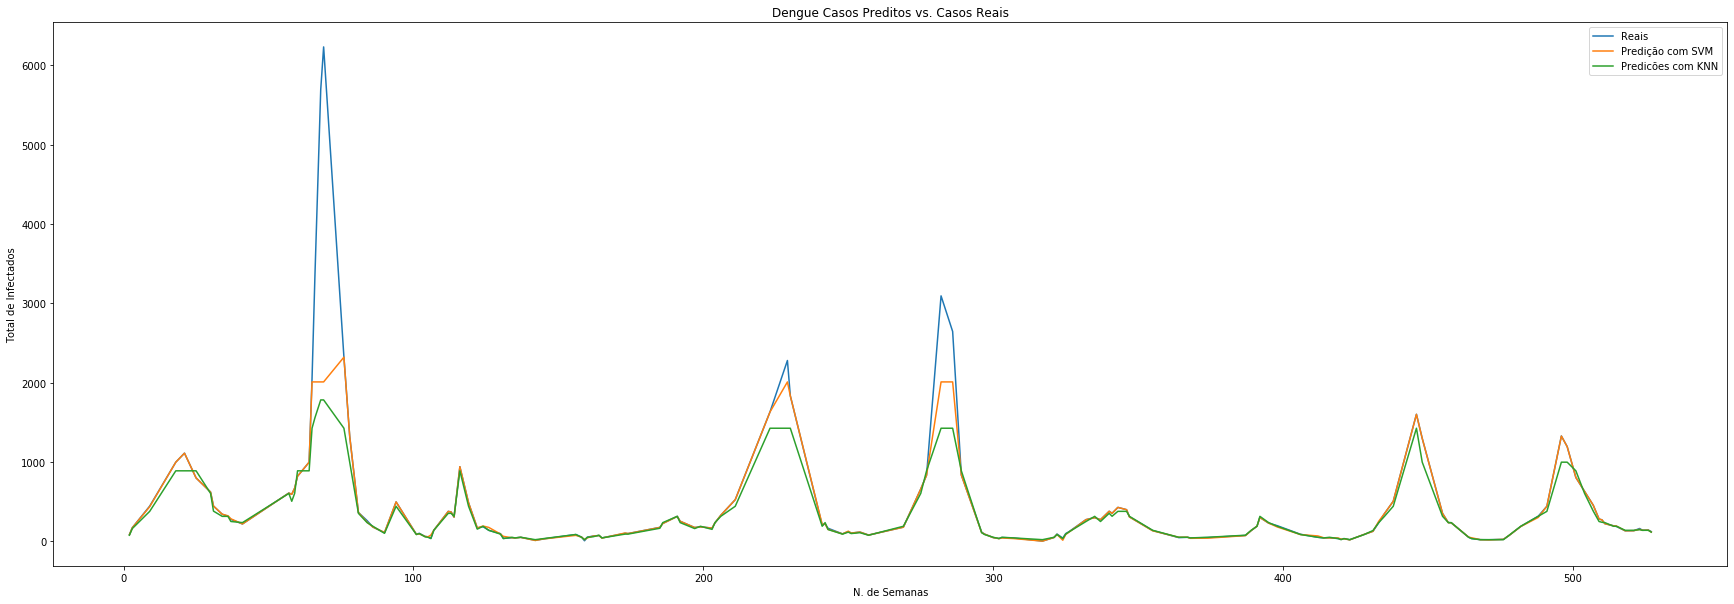

In [336]:
plt.figure(figsize=(30,10))
train_subtest.Infectados.plot(label="Reais")
train_subtest.fitted.plot( label="Predição com SVM")
train_subtest.fitted2.plot( label="Predicões com KNN")

plt.title("Dengue Casos Preditos vs. Casos Reais")
plt.legend()
plt.xlabel('N. de Semanas')
plt.ylabel('Total de Infectados')

Text(0, 0.5, 'Total de Infectados')

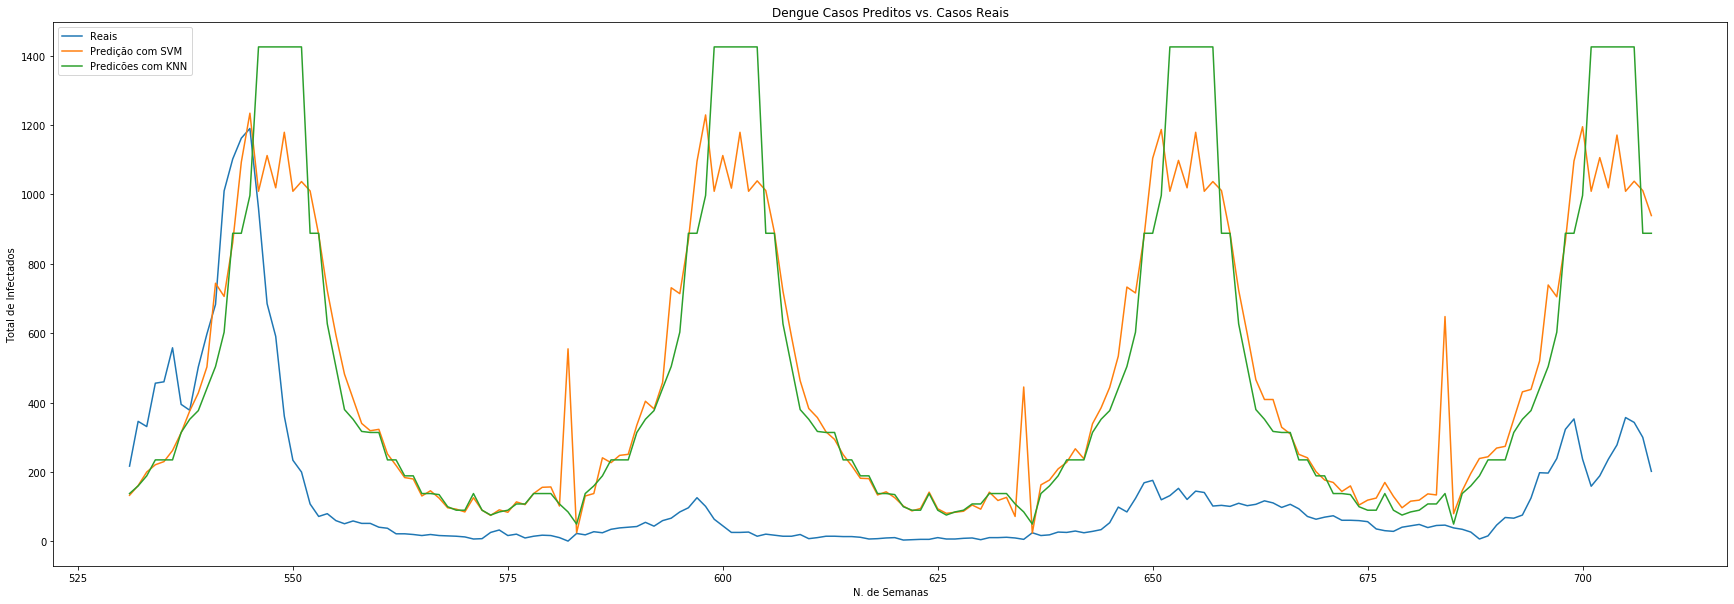

In [337]:
plt.figure(figsize=(30,10))
submission['Infectados'].plot(label="Reais")
X_test.fitted.plot( label="Predição com SVM")
X_test.fitted2.plot( label="Predicões com KNN")

plt.title("Dengue Casos Preditos vs. Casos Reais")
plt.legend()
plt.xlabel('N. de Semanas')
plt.ylabel('Total de Infectados')

## Calcula as métricas  - Cross validation com o score R2

### Scores para SVR

In [338]:
scores = cross_val_score(svr, X,Y, cv=5, scoring = "r2")
print("Scores usando SVR:", scores)
print("Média  usando SVR:", scores.mean())

Scores usando SVR: [0.13742521 0.78868571 0.30286484 0.96675582 0.7931953 ]
Média  usando SVR: 0.5977853753570249


### Scores para KNN

In [339]:
scores = cross_val_score(knn, X,Y, cv=5, scoring = "r2")
print("Scores usando KNN:", scores)
print("Média  usando KNN:", scores.mean())

Scores usando KNN: [0.47946405 0.48832127 0.57281525 0.59726986 0.5703846 ]
Média  usando KNN: 0.5416510051977255


## Predição com dados de TESTE 

### Predição KNN

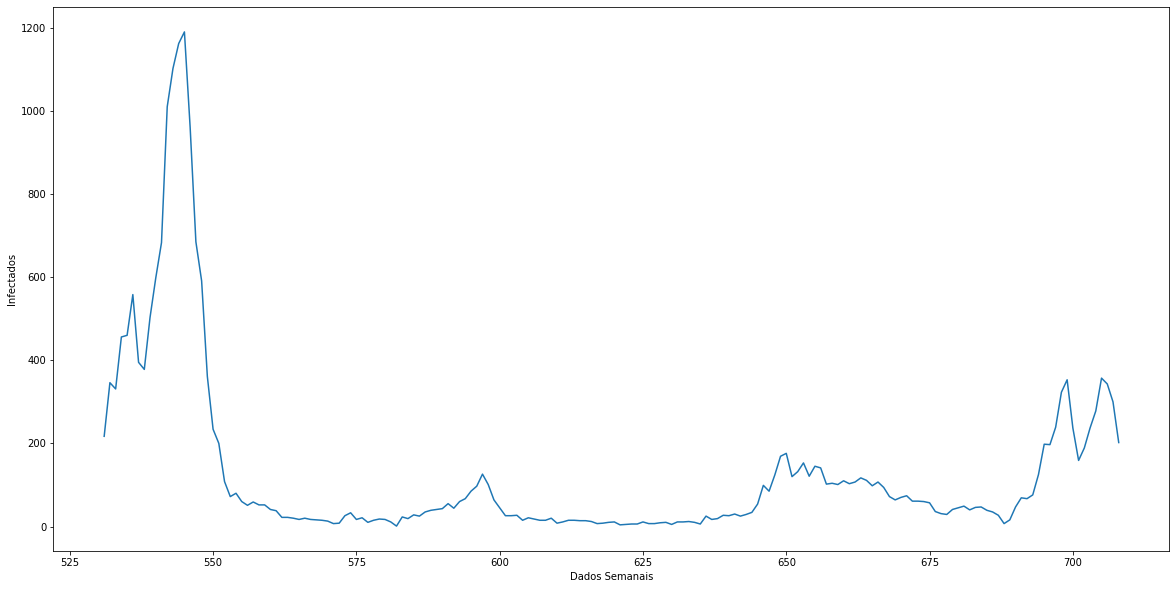

In [340]:
# Dados de "Infectados" de teste
plt.figure(figsize=(20,10))
plt.xlabel('Dados Semanais')
plt.ylabel('Infectados')
plt.plot(submission['Infectados'])
plt.show()


Text(0, 0.5, 'Total de Infectados')

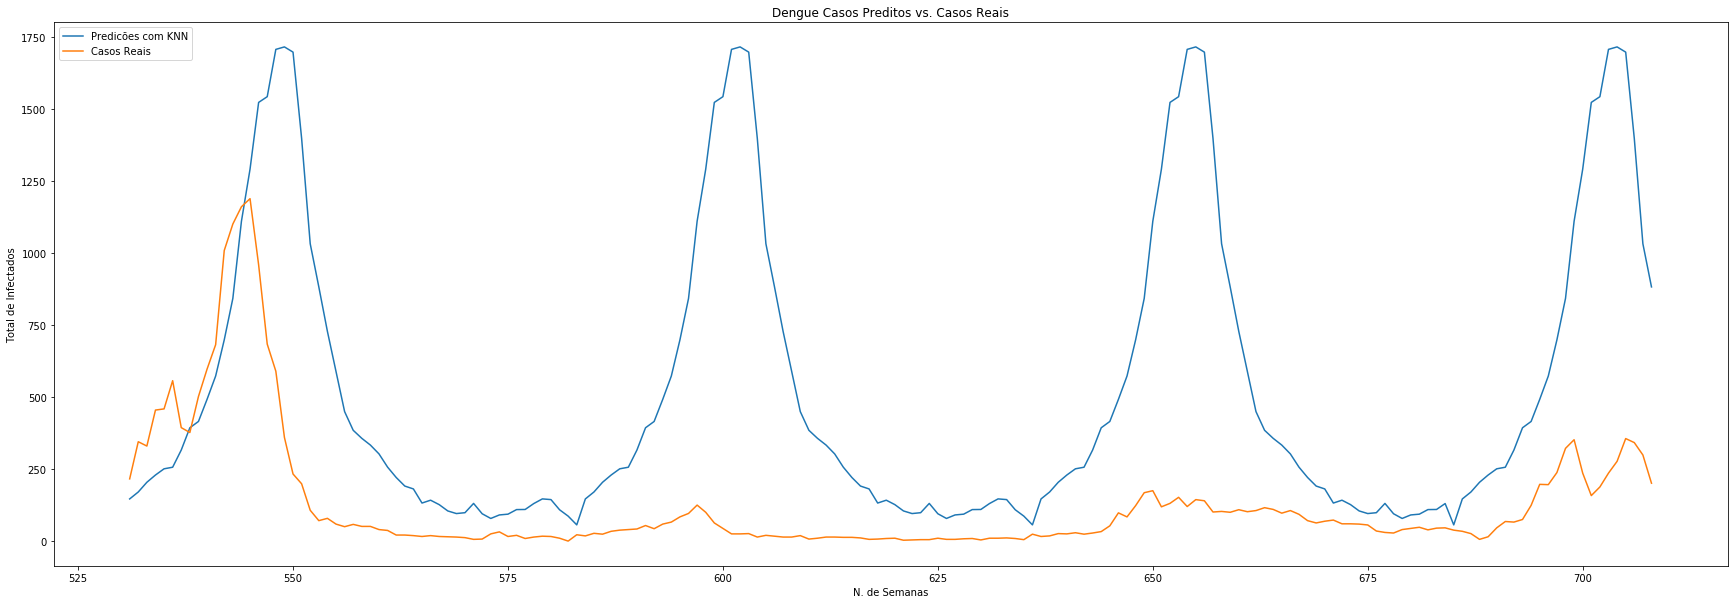

In [341]:

predictions = knn.predict(Xt).astype(int)
#submission['Infectados'] = np.concatenate([predictions])

plt.figure(figsize=(30,10))
X_test.Infectados.plot(label="Predicões com KNN")

submission['Infectados'].plot( label="Casos Reais")

plt.title("Dengue Casos Preditos vs. Casos Reais")
plt.legend()
plt.xlabel('N. de Semanas')
plt.ylabel('Total de Infectados')

### Predição SVM

Text(0, 0.5, 'Total de Infectados')

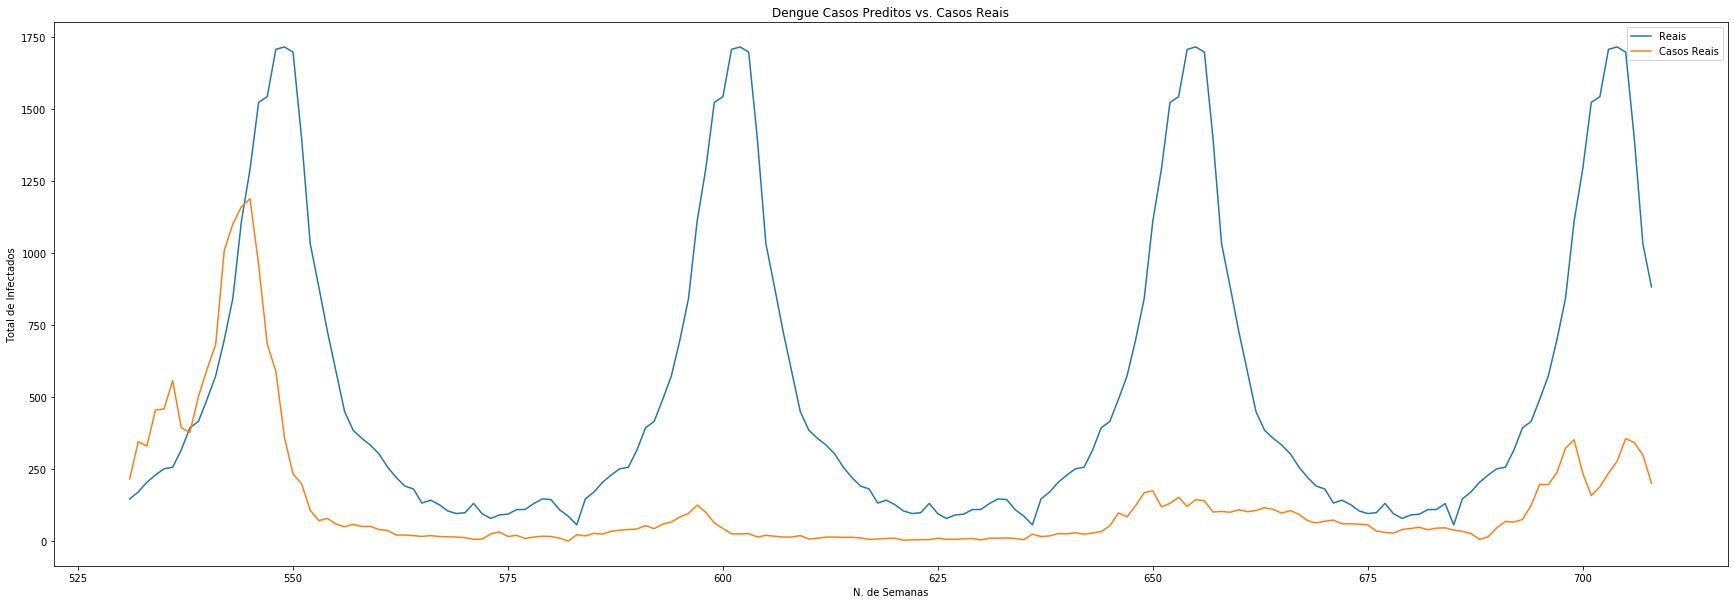

In [342]:
#Predição SVM

predictions2 = model.predict(Xt).astype(int)

#submission.Infectados = np.concatenate([predictions2])

plt.figure(figsize=(30,10))
X_test.Infectados.plot(label="Reais")

submission['Infectados'].plot( label="Casos Reais")

plt.title("Dengue Casos Preditos vs. Casos Reais")
plt.legend()
plt.xlabel('N. de Semanas')
plt.ylabel('Total de Infectados')

## Conclusão
### Podemos afirmar que os modelos baseados em SVM KNN funcionam muito bem para previsão de casos dengue em Fortaleza, com uma precisão maior para o modelo baseado no KNN